In [1]:
import os
import pandas as pd

print("=" * 70)
print("GENERATING MANIFEST.CSV")
print("=" * 70)

# Data path
base_path = r'../data_recordings'

print(f"\n Base path: {base_path}")

rows = []

print("\n Processing ACCEPTED...")
accepted_folder = os.path.join(base_path, 'accepted')
if os.path.exists(accepted_folder):
    for speaker_folder in os.listdir(accepted_folder):
        speaker_path = os.path.join(accepted_folder, speaker_folder)
        if os.path.isdir(speaker_path):
            file_count = 0
            for file in os.listdir(speaker_path):
                if file.endswith(('.wav', '.mp3', '.flac')):
                    relative_path = os.path.join('accepted', speaker_folder, file)
                    rows.append({
                        'speaker_id': speaker_folder,
                        'path': relative_path,
                        'label': 1  # 1 = ACCEPTED
                    })
                    file_count += 1
            print(f"{speaker_folder}: {file_count} files")
else:
    print(f"Not found: {accepted_folder}")

print("\nProcessing REJECTED...")
rejected_folder = os.path.join(base_path, 'rejected')
if os.path.exists(rejected_folder):
    for speaker_folder in os.listdir(rejected_folder):
        speaker_path = os.path.join(rejected_folder, speaker_folder)
        if os.path.isdir(speaker_path):
            file_count = 0
            for file in os.listdir(speaker_path):
                if file.endswith(('.wav', '.mp3', '.flac')):
                    relative_path = os.path.join('rejected', speaker_folder, file)
                    rows.append({
                        'speaker_id': speaker_folder,
                        'path': relative_path,
                        'label': 0  # 0 = REJECTED
                    })
                    file_count += 1
            print(f"  {speaker_folder}: {file_count} files")
else:
    print(f" Not found: {rejected_folder}")

df = pd.DataFrame(rows)
manifest_file = os.path.join(base_path, 'manifest.csv')
df.to_csv(manifest_file, index=False)

print("\n" + "=" * 70)
print("MANIFEST GENERATED SUCCESFULLY")
print("=" * 70)
print(f"\nArchive: {manifest_file}")
print(f"Total archives: {len(df)}")
print(f"  • Accepted (label=1): {sum(df['label'] == 1)}")
print(f"  • Rejected (label=0): {sum(df['label'] == 0)}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nColumns: {df.columns.tolist()}")


GENERATING MANIFEST.CSV

 Base path: data_recordings

 Processing ACCEPTED...
p001: 718 files
p239: 900 files
p243: 900 files
p259: 901 files
p268: 901 files
p270: 900 files

Processing REJECTED...
  p226: 302 files
  p227: 300 files
  p228: 300 files
  p230: 301 files
  p231: 300 files
  p232: 300 files
  p233: 301 files
  p236: 300 files
  p244: 300 files
  p250: 300 files
  p254: 300 files
  p256: 300 files
  p257: 300 files
  p258: 300 files
  p267: 300 files
  p269: 300 files
  p273: 300 files
  p274: 300 files
  p276: 300 files
  p277: 301 files

MANIFEST GENERATED SUCCESFULLY

Archive: data_recordings\manifest.csv
Total archives: 11225
  • Accepted (label=1): 5220
  • Rejected (label=0): 6005

First 5 rows:
  speaker_id                            path  label
0       p001  accepted\p001\p001_001_000.wav      1
1       p001  accepted\p001\p001_001_001.wav      1
2       p001  accepted\p001\p001_001_002.wav      1
3       p001  accepted\p001\p001_002_000.wav      1
4       p001  ac

In [ ]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from keras import backend as K
import keras
from sklearn.model_selection import train_test_split   # kept, though no longer used
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("SPEAKER VERIFICATION - CNN WITH MEL-SPECTROGRAMS")
print("=" * 70)


# Initialization of paths
base_path = r'../data_recordings'
manifest_path = os.path.join(base_path, 'manifest.csv')


MAX_SAMPLES = None # TODO what's this?

# Activating dropout
dropout = False
dropout_low = False

# ### Ratios for 3-way split
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15
RANDOM_STATE = 42 # TODO what's this?




print(f"\nConfiguration:")
print(f"  Base path: {base_path}")
print(f"  Manifest: {manifest_path}")
print(f"  Max samples: {MAX_SAMPLES if MAX_SAMPLES else 'All'}")
print(f"  Split ratios (train/val/test): {TRAIN_RATIO}/{VAL_RATIO}/{TEST_RATIO}")

print("\n" + "=" * 70)
print("VERIFYING FILES AND PATHS")
print("=" * 70)

# Checking base folder and manifest
if not os.path.exists(base_path):
    raise FileNotFoundError(f"Base folder not found: {base_path}")
print("Base folder found")

if not os.path.exists(manifest_path):
    print("\nPlease run first: python run_pipeline_to_get_data.py")
    raise FileNotFoundError("manifest.csv not found")
print("Manifest found")




print("\n" + "=" * 70)
print("STEP 1: LOADING DATA FROM MANIFEST.CSV")
print("=" * 70)

df = pd.read_csv(manifest_path)
print(f"\nTotal entries: {len(df)}")

if MAX_SAMPLES:
    df = df.head(MAX_SAMPLES)

print(f"\nFirst 5 rows:")
print(df.head())

if 'path' not in df.columns or 'label' not in df.columns:
    raise ValueError("Incorrect manifest format")

print(f"\nClass distribution:")
print(f"  Accepted: {sum(df['label'] == 1)}")
print(f"  Rejected: {sum(df['label'] == 0)}")

# ### Extract speaker ID from the path
# Assumes something like: accepted/p001/file.wav  -> speaker 'p001'
df['speaker'] = df['path'].apply(lambda p: os.path.basename(os.path.dirname(p)))

print("\nNumber of unique speakers:", df['speaker'].nunique())
print("Sample speakers:", df['speaker'].unique()[:10])

def load_audio_file(file_path, base_folder, sr=22050, max_duration=3):
    full_path = os.path.join(base_folder, file_path)
    try:
        y, _ = librosa.load(full_path, sr=sr, duration=max_duration)
        y = y / (np.max(np.abs(y)) + 1e-6)
        y, _ = librosa.effects.trim(y, top_db=20)
        
        target_length = sr * max_duration
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)))
        else:
            y = y[:target_length]
        return y
    except:
        return None

print("\n" + "=" * 70)
print("STEP 2: LOADING AUDIO FILES")
print("=" * 70)

audio_data = []
labels = []
speakers = []   # keep track of speaker for each loaded sample
failed = 0

for idx, row in df.iterrows():
    audio = load_audio_file(row['path'], base_path)
    if audio is not None:
        audio_data.append(audio)
        labels.append(row['label'])
        speakers.append(row['speaker'])
    else:
        failed += 1
    
    if (idx + 1) % 50 == 0:
        print(f"  Processed {idx + 1}/{len(df)} files...")

print(f"\nLoading completed: {len(audio_data)} files")
if failed > 0:
    print(f"Failed: {failed}")

if len(audio_data) == 0:
    raise ValueError("No data to train")



print("\n" + "=" * 70)
print("STEP 3: GENERATING MEL-SPECTROGRAMS")
print("=" * 70)

def audio_to_spectrogram(y, sr=22050, n_mels=128):
    # Function for creating spectrograms from audio files
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db[..., np.newaxis]

spectrograms = []
for i, audio in enumerate(audio_data):
    spectrograms.append(audio_to_spectrogram(audio))
    if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(audio_data)} spectrograms...")

spectrograms = np.array(spectrograms)
labels = np.array(labels)
speakers = np.array(speakers)

print(f"\nSpectrograms shape: {spectrograms.shape}")

def _get_recording_group_key(path, speaker):
    """
    Given a relative path like 'accepted/p226/p226_003_000.wav',
    return a deterministic group key.

    For most speakers: group by (speaker, original_recording_id) where
    original_recording_id is the middle number in 'p226_003_000'.

    For accepted/p001: treat each file as its own group (no special grouping).
    """
    norm_path = path.replace("\\", "/")
    basename = os.path.basename(norm_path)
    stem, _ = os.path.splitext(basename)
    parts = stem.split("_")

    # Special case: manual recordings
    if "/accepted/" in norm_path and speaker == "p001":
        return f"{speaker}|{stem}"

    # Typical auto-split pattern: pXXX_###_###
    if len(parts) >= 3 and parts[0] == speaker and parts[1].isdigit() and parts[2].isdigit():
        # use the middle number as "original recording" id
        original_id = parts[1]               
        return f"{speaker}|{original_id}"



def split_by_speaker_and_recording(
    X, y, speakers,
    train_ratio=0.7, val_ratio=0.15, test_ratio=0.15
):
    """
    3-way split:
      - per speaker
      - keeping all segments from the same original recording together
      - except for manual recordings TODO why?
    """

    # Checking if data is loaded succesfully
    if not (len(X) == len(y) == len(speakers)):
        raise ValueError("X, y and speakers must have the same length")

    # We rely on the fact that each loaded sample corresponds to the same row in df.
    # If some files failed to load, we stop rather than mis-align.
    if 'failed' in globals() and failed != 0:
        raise ValueError(
            "Splitting assumes all files loaded successfully (failed == 0). "
            "Got failed != 0; please adjust loading logic or splitting."
        )
    if len(df) != len(X):
        raise ValueError(
            f"Length mismatch between df ({len(df)}) and data ({len(X)}). "
            "Splitting by recording cannot be done safely."
        )

    # Build groups: (speaker, recording_group_key) -> list of sample indices
    groups_per_speaker = {} 
    for idx, spk in enumerate(speakers):
        path = df.loc[idx, "path"]
        group_key = _get_recording_group_key(path, spk)

        if spk not in groups_per_speaker:
            groups_per_speaker[spk] = {}
        if group_key not in groups_per_speaker[spk]:
            groups_per_speaker[spk][group_key] = []
        groups_per_speaker[spk][group_key].append(idx)

    train_idx, val_idx, test_idx = [], [], []

    for spk in sorted(groups_per_speaker.keys()):
        group_dict = groups_per_speaker[spk]
        grouped_items = sorted(group_dict.items(), key=lambda kv: kv[0])

        # Total samples for this speaker
        all_indices = [i for _, idxs in grouped_items for i in idxs]
        n_total = len(all_indices)

        target_train = int(round(train_ratio * n_total))
        target_val = int(round(val_ratio * n_total))
        n_train = n_val = 0

        for group_key, idxs in grouped_items:
            gsize = len(idxs)

            if n_train + gsize <= target_train:
                train_idx.extend(idxs)
                n_train += gsize
            elif n_val + gsize <= target_val:
                val_idx.extend(idxs)
                n_val += gsize
            else:
                test_idx.extend(idxs)

    train_idx = np.array(sorted(train_idx))
    val_idx = np.array(sorted(val_idx))
    test_idx = np.array(sorted(test_idx))

    return (
        X[train_idx], X[val_idx], X[test_idx],
        y[train_idx], y[val_idx], y[test_idx]
    )


X_train, X_val, X_test, y_train, y_val, y_test = split_by_speaker_and_recording(
    spectrograms,
    labels,
    speakers,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO
)


print(f"\nFinal split sizes:")
print(f"  Train:      {X_train.shape[0]}")
print(f"  Validation: {X_val.shape[0]}")
print(f"  Test:       {X_test.shape[0]}")

SPEAKER VERIFICATION - CNN WITH MEL-SPECTROGRAMS

Configuration:
  Base path: data_recordings
  Manifest: data_recordings\manifest.csv
  Max samples: All
  Split ratios (train/val/test): 0.7/0.15/0.15

VERIFYING FILES AND PATHS
Base folder found
Manifest found

STEP 1: LOADING DATA FROM MANIFEST.CSV


KeyboardInterrupt: 


STEP 4: BUILDING AND TRAINING CNN


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 128, 130, 1)    │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 130, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 65, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,236 (16.35 MB)

 Trainable params: 4,287,233 (16.35 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 71s 137ms/step - accuracy: 0.6104 - loss: 0.6536 - val_accuracy: 0.8305 - val_loss: 0.4285
Epoch 2/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 70s 142ms/step - accuracy: 0.8339 - loss: 0.3730 - val_accuracy: 0.8757 - val_loss: 0.3135
Epoch 3/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 72s 146ms/step - accuracy: 0.8946 - loss: 0.2539 - val_accuracy: 0.9191 - val_loss: 0.1955
Epoch 4/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 76s 155ms/step - accuracy: 0.9300 - loss: 0.1756 - val_accuracy: 0.9405 - val_loss: 0.1575
Epoch 5/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 80s 162ms/step - accuracy: 0.9431 - loss: 0.1454 - val_accuracy: 0.9471 - val_loss: 0.1428
Epoch 6/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 77s 156ms/step - accuracy: 0.9606 - loss: 0.1058 - val_accuracy: 0.9310 - val_loss: 0.1789
Epoch 7/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 77s 157ms/step - accuracy: 0.9653 - loss: 0.0903 - val_accuracy: 0.9595 - val_loss: 0.1253
Epoch 8/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 82s 167ms/step - accuracy: 0.9754 - loss: 0

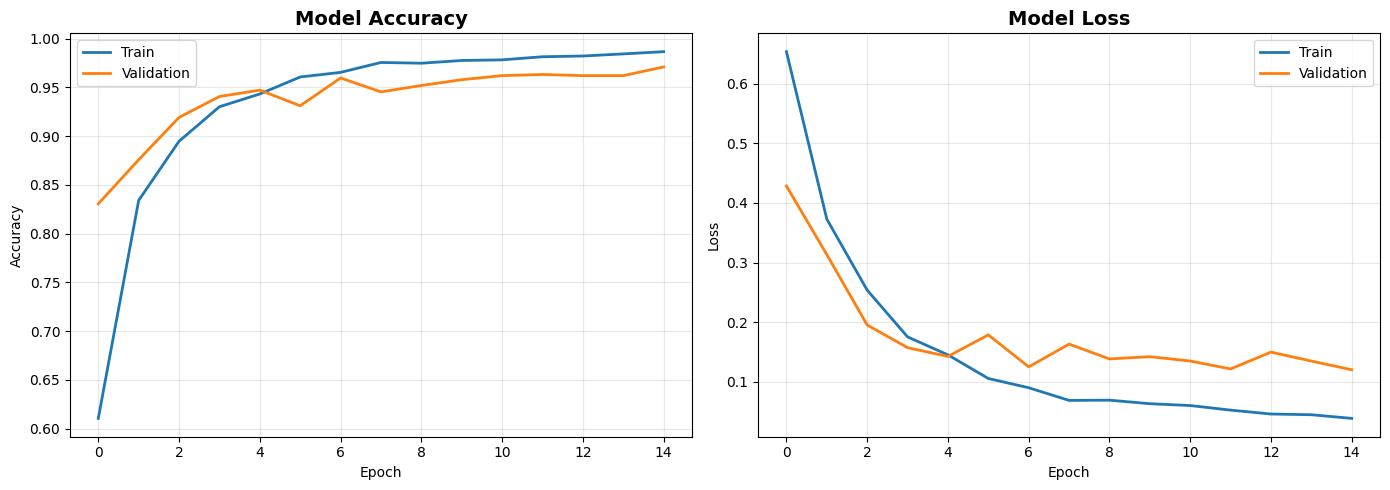

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step

TEST ACCURACY: 96.20%

              precision    recall  f1-score   support

    Rejected       0.98      0.95      0.96       902
    Accepted       0.95      0.97      0.96       783

    accuracy                           0.96      1685
   macro avg       0.96      0.96      0.96      1685
weighted avg       0.96      0.96      0.96      1685



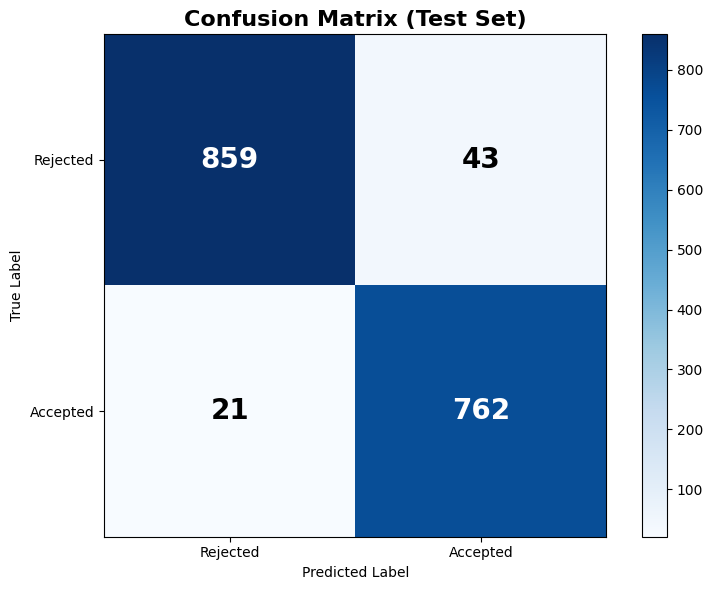


TRAINING COMPLETED SUCCESSFULLY!

Generated files:
  • training_history.png
  • confusion_matrix.png
  • test_results.csv
  • speaker_verification_model.h5


In [ ]:
print("\n" + "=" * 70)
print("STEP 4: BUILDING AND TRAINING CNN")
print("=" * 70)


norm_layer = layers.Normalization()
norm_layer.adapt(X_train)


# Building models

def build_cnn_model(input_shape, norm):
    # default model (without dropout or anything)
    return models.Sequential([
        layers.Input(shape=input_shape),
        norm,
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

def build_cnn_model_dropout(input_shape, norm):
    # model with dropout
    return models.Sequential([
        layers.Input(shape=input_shape),
        norm,
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

def build_cnn_model_dropout_low(input_shape, norm):
    # model with low dropout (for comparison)
    return models.Sequential([
        layers.Input(shape=input_shape),
        norm,
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])


# Checking which model to use
if (dropout):
    model = build_cnn_model_dropout(X_train.shape[1:], norm_layer)
elif(dropout_low):
    model = build_cnn_model_dropout_low(X_train.shape[1:], norm_layer)
else:
    model = build_cnn_model(X_train.shape[1:], norm_layer)

# Show model
model.summary()


# TODO try out different optimizers
opts = [
    'SGD',
    'RMSprop',
    'Adam',
    'AdamW',
    'Adadelta',
    'Adagrad',
    'Adamax',
    'Adafactor',
    'Nadam',
    'Ftrl',
    'Lion',
    'Lamb',
    'Loss Scale Optimizer',
    'Muon'
]
# opt = keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# If training is fast, we can stop early
# TODO check if values (e.g. patience) can be improved
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val), 
    epochs=15,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

print("\n" + "=" * 70)
print("STEP 5: EVALUATION AND RESULTS (ON TEST SET)")
print("=" * 70)


#Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['loss'], label='Train', linewidth=2)
ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

y_test_pred_prob = model.predict(X_test)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTEST ACCURACY: {test_accuracy*100:.2f}%\n")
print(classification_report(y_test, y_test_pred, target_names=['Rejected', 'Accepted']))

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix (Test Set)', fontsize=16, fontweight='bold')
plt.colorbar()

classes = ['Rejected', 'Accepted']
plt.xticks([0, 1], classes)
plt.yticks([0, 1], classes)

thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=20, fontweight='bold')

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

results_df = pd.DataFrame({
    'true_label': y_test,
    'predicted_label': y_test_pred,
    'confidence': y_test_pred_prob.flatten()
})
results_df.to_csv('test_results.csv', index=False)

# Saving model
model.save('speaker_verification_model.h5')


print("\n" + "=" * 70)
print("TRAINING COMPLETED SUCCESSFULLY!")
print("=" * 70)
print("\nGenerated files:")
print("  • training_history.png")
print("  • confusion_matrix.png")
print("  • test_results.csv")
print("  • speaker_verification_model.h5")
